# Traditional task allocation strategies

In this notebook, two traditional task allocation strategies are implemented. 
- Auction based approach 
- Vacancy-chain approach 

There are two different environements considered. 
1. Simple grid environement where each square represents a unique location. 
2. Complex graph network environments which consists of nodes and edges that form connections between the nodes. 

## Import necessary libraries 

In [89]:
import math as m 
import random 
import numpy as np 
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

## Auction-based approach

In [116]:
def euclidean(robot, task): 
     return m.sqrt((robot[0]-task[0])**2 + (robot[1] - task[1])**2)

def auction(robot_locations, task_locations, G=None): 
     assigned_tasks = {}
     no_robots = len(robot_locations)
     no_tasks = len(task_locations)
     for i in range(no_robots): 
         assigned_tasks['robot {}'.format(i)] = [robot_locations[i]]
     
     for t in range(no_tasks): 
          cost = []
          for r in range(no_robots): 
               if G==None:
                    cost.append(euclidean(assigned_tasks['robot {}'.format(r)][-1], task_locations[t]))
               else: 
                    cost.append(cost_graph_simple(G, assigned_tasks['robot {}'.format(r)][-1], task_locations[t]))
                    
          winner = cost.index(min(cost))
          assigned_tasks['robot {}'.format(winner)].append(task_locations[t])

     return assigned_tasks

                           
def generate_scene(map_size, no_robots, no_tasks): 
     robot_locations = []
     task_locations = []
     for i in range(no_robots): 
          robot_locations.append((random.randint(0, map_size-1), random.randint(0, map_size-1)))
     for j in range(no_tasks): 
          task_locations.append((random.randint(0, map_size-1), random.randint(0, map_size-1)))

     map = np.zeros(shape=(map_size, map_size))
     for task in task_locations: 
          map[task[0], task[1]] = 1
     for robot in robot_locations: 
          map[robot[0], robot[1]] = 2

     return task_locations, robot_locations, map

def vizmap(map): 
     return sns.heatmap(map, cbar=False, linecolor='black', linewidths=1.0, cmap=['white', 'red', 'blue'])

def generate_network(num_nodes, connection_prob=0.1): 
    G = nx.Graph()
    nodes = list(range(num_nodes))
    G.add_nodes_from(nodes)

    for i in range(num_nodes): 
        for j in range(num_nodes): 
            chance = random.randint(0, 100)
            if j == i: 
                continue
            if chance < connection_prob*100: 
                G.add_edge(i, j)
    for node in list(G.nodes): 
        if len(list(G.neighbors(node))) < 1: 
            G.add_edge(node, nodes[random.randint(0, num_nodes - 1)])

    return G

def cost_graph_simple(graph, start, finish): 
    return len(nx.shortest_path(graph, start, finish))-1

def generate_scene_network(no_robots, no_tasks, no_nodes, connection_prob): 
    robot_locations = []
    task_locations = []
    for i in range(no_robots): 
        robot_locations.append(random.randint(0, no_nodes-1))
    for j in range(no_tasks): 
        task_locations.append(random.randint(0, no_nodes-1))
    
    G = generate_network(no_nodes, connection_prob)

    return task_locations, robot_locations, G 


### Test the implementation (Network graph)

In [222]:
task_locations, robot_locations, G = generate_scene_network(2, 3, 10, 0.5)
task_alloc = auction(robot_locations, task_locations, G)
task_alloc

{'robot 0': [7, 5, 4], 'robot 1': [8, 6]}

In [223]:
robot_locations

[7, 8]

In [224]:
task_locations

[5, 6, 4]

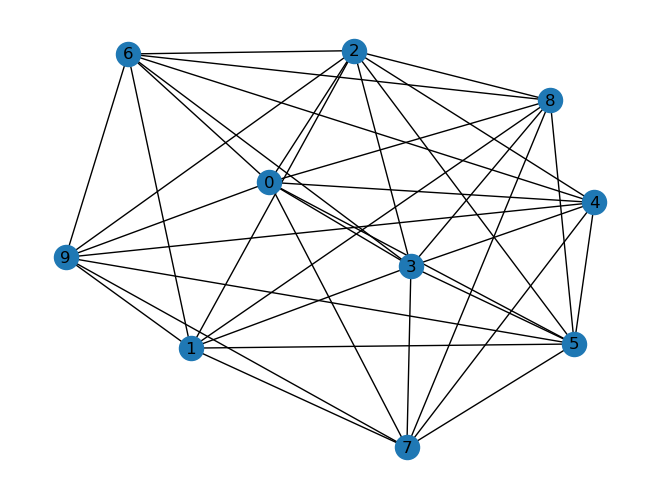

In [225]:
nx.draw_spring(G, with_labels=True)

In [248]:
# task_locations_2, robot_locations_2, map = generate_scene(30, 5, 10)
robot_locations_2, task_locations_2, map = generate_scene(5, 3, 2)

<Axes: >

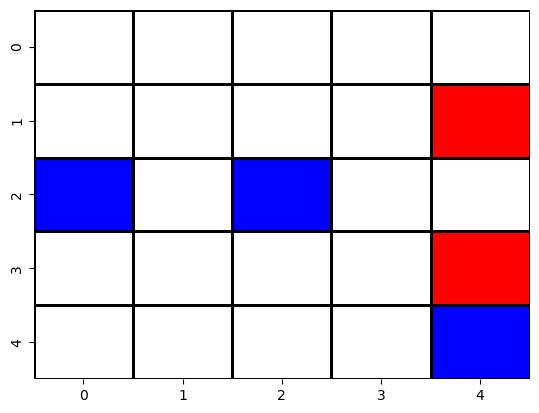

In [249]:
vizmap(map)

In [250]:
task_alloc = auction(robot_locations_2, task_locations_2, G=None)
task_alloc

{'robot 0': [(1, 4), (2, 2), (2, 0)], 'robot 1': [(3, 4), (4, 4)]}

## Vacancy-chain approach

In [251]:
class robot: 
    def __init__(self, robot_location):
        self.current_location = robot_location 
        self.assigned_tasks = []

    def non_greedy(self, unexplored, G=None): 
        total_cost = 0
        prob_dist = []
        if G == None: # simple grid case 
            for i in range(len(unexplored)): 
                total_cost += 1/euclidean(self.current_location, unexplored[i])
            for j in range(len(unexplored)): 
                num = 1/euclidean(self.current_location, unexplored[j])
                prob_dist.append(num/total_cost)
        else: # graph network case 
            for i in range(len(unexplored)): 
                total_cost += 1/cost_graph_simple(G, self.current_location, unexplored[i])
            for j in range(len(unexplored)): 
                num = 1/cost_graph_simple(G, self.current_location, unexplored[j])
                prob_dist.append(num/total_cost)     
        
        winner = prob_dist.index(max(prob_dist))
        chosen_task = unexplored[winner]

        return winner, 1/num
    
    def get_broadcasts(self, another_robot, unexplored, G=None): 
        win=True
        chosen_task, cost = self.non_greedy(unexplored, G)
        other_chosen_task, other_cost = another_robot.non_greedy(unexplored, G)
        if chosen_task == other_chosen_task: 
            if cost > other_cost: 
                win=False 
        return win 

            
def vacancy_chain(robots, unexplored, G=None, allocs={}): 
    if len(unexplored) == 0: 
        return allocs, robots
    vacant = []
    for r in range(len(robots)): 
        vacant.append(False)
    u = 0
    if allocs == {}: 
        for robot in robots: 
            allocs['Robot {}'.format(u)] = [robot.current_location]
            u += 1
    for i in range(len(robots)): 
        asg = True
        if len(unexplored) == 0: 
            break
        for j in range(len(robots)): 
            if j==i: 
                continue
            elif vacant[j]: 
                continue
            else:
                win = robots[i].get_broadcasts(robots[j], unexplored, G)
                if not win: 
                    asg = False
        if asg: 
            winner, _ = robots[i].non_greedy(unexplored, G)
            robots[i].assigned_tasks.append(unexplored[winner])
            allocs['Robot {}'.format(i)].append(unexplored.pop(winner))
            vacant[i]=True   
            
    
    for s in range(len(vacant)): 
        if not vacant[s]: 
            if (len(unexplored)) > 0: 
                winner, _ = robots[s].non_greedy(unexplored, G)
                robots[s].assigned_tasks.append(unexplored[winner])
                allocs['Robot {}'.format(s)].append(unexplored.pop(winner))
                vacant[s]=True  
             
    return vacancy_chain(robots, unexplored, G, allocs)



### Test implementation

For this implementation, it is crucial that the task, map and robot locations are compatible. Which means that: 
1. There should be no repeated task locations. 
2. There should not be a task location that coincides with a robot location. 
3. The robots should be in distinct locations. 
4. The map should be connected in the sense that it is possible to move from any node to any other node through some path. 

In [252]:
robots = [] 
robot_locations 
task_locations 
for i in range(len(robot_locations)): 
    robots.append(robot(robot_locations[i]))

In [253]:
task_locations

[5, 6, 4]

In [254]:
robot_locations

[7, 8]

In [255]:
G

In [256]:
allocs, robots = vacancy_chain(robots, task_locations, G, allocs={})

In [257]:
allocs

{'Robot 0': [7, 5, 4], 'Robot 1': [8, 6]}

In [258]:
task_locations

[]

In [259]:
robots2 = []
robot_locations_2 
task_locations_2
for i in range(len(robot_locations_2)): 
    robots2.append(robot(robot_locations_2[i]))

In [260]:
robots2

[<__main__.robot at 0x7fba81cda630>, <__main__.robot at 0x7fba89370350>]

In [261]:
allocs2, robots2_final = vacancy_chain(robots2, task_locations_2, G=None, allocs={})

In [262]:
allocs2

{'Robot 0': [(1, 4), (2, 2), (2, 0)], 'Robot 1': [(3, 4), (4, 4)]}